In [2]:
import os
import random

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

from evaluator import evaluate
from data_loader import load_kdd_cup_urc, load_yahoo_A1, load_yahoo_A2, load_yahoo_A3, load_yahoo_A4, load_power_demand # Univariate Datasets
from data_loader import load_nasa, load_ecg, load_gesture, load_smd # Multivariate Datasets

from tqdm.notebook import tqdm
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, LSTMCell, GRU, GRUCell, Reshape, Dropout, GaussianNoise, Concatenate, Lambda, RepeatVector, TimeDistributed

# THESE LINES ARE FOR REPRODUCIBILITY
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [4]:
datasets = load_yahoo_A1(128, 64)
X_train, X_test = datasets['x_train'][0], datasets['x_test'][0]

  0%|          | 0/67 [00:00<?, ?it/s]

In [101]:
sparseness_weights = [(0, 1), (1, 0), (1, 1)]

class SkipRNN(tf.keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(self.cell, "get_initial_state", self.fallback_initial_state)
        
    def fallback_initial_state(self, inputs):
        return [tf.zeros([self.cell.state_size], dtype=inputs.dtype)]
    
    @tf.function
    def call(self, inputs):
        init_states = self.get_initial_state(inputs)
        n_steps = tf.shape(inputs)[1]
        
        skip_length = np.random.randint(low=2, high=10, size=1)[0]
        w1, w2 = np.array(sparseness_weights)[np.random.choice(3, size=1)][0]
        w1, w2 = tf.convert_to_tensor(w1, dtype=float), tf.convert_to_tensor(w2, dtype=float)
        w = w1 + w2
        
        print(skip_length, w1, w2, w)
                
#         if self.return_sequences:

        sequences = tf.TensorArray(inputs.dtype, size=n_steps)
        outputs = tf.zeros(shape=[n_steps, self.cell.output_size], dtype=inputs.dtype)
        prev_states = []
        prev_states.append(init_states)
        
        for step in tf.range(n_steps):
            if step == 0:
                outputs, states = self.cell(inputs[:, step], prev_states.pop())
                prev_states.append(states)
            else:
                idx = step - skip_length
                if idx >= 0:
                    states = w1 * tf.convert_to_tensor(prev_states.pop()) + w2 * tf.convert_to_tensor(prev_states.pop(idx)) / w
                    outputs, states = self.cell(inputs[:, step], states)
                    prev_states.append(states)
                else:
                    outputs, states = self.cell(inputs[:, step], prev_states.pop())
                    prev_states.append(states)
            
            if self.return_sequences:
                sequences = sequences.write(step, outputs)

        if self.return_sequences:
            return sequences.stack()
        else:
            return outputs
        
# def MR_TAD(X_train):
#     tf.keras.backend.clear_session()
#     BATCH_SIZE = 128
#     N, N_LAYERS = 3, 1
    
#     X_train_reverse = np.flip(X_train, axis=1)
#     seq_length, dim = X_train.shape[1], X_train.shape[2]
    
#     en_input = Input(shape=[seq_length, dim])
#     de_output = []
    
#     for 
    
    
#     model = Model(inputs=en_input, outputs=de_outputs)
#     return model

In [102]:
tf.keras.backend.clear_session()

BATCH_SIZE = 128
N, N_LAYERS, N_UNITS = 1, 1, 64

X_train_reverse = np.flip(X_train, axis=1)
seq_length, dim = X_train.shape[1], X_train.shape[2]

en_input = Input(shape=[seq_length, dim])
X = GaussianNoise(0.5)(en_input)
initial_states = tf.zeros([BATCH_SIZE, N_UNITS])

shared_latents = []
for i in range(N):
    H = SkipRNN(LSTMCell(32))(X)
    shared_latents.append(H)

de_outputs = []
de_input = Concatenate()(shared_latents)
D = Dense(dim, activation='relu')(de_input)

for i in range(N):
    H = RepeatVector(seq_length)(D)
    output = SkipRNN(LSTMCell(dim), return_sequences=True)(H)
    output = TimeDistributed(Dense(dim))(H)
    output = Reshape([seq_length, dim])(output)
    de_outputs.append(output)

model = Model(en_input, de_outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

history = model.fit(X_train, [X_train_reverse for _ in range(N)], batch_size=BATCH_SIZE, epochs=1, validation_split=0.3, verbose=0,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min", restore_best_weights=True)]) 

2 Tensor("Const:0", shape=(), dtype=float32) Tensor("Const_1:0", shape=(), dtype=float32) Tensor("add:0", shape=(), dtype=float32)


TypeError: in user code:

    <ipython-input-101-1de723984711>:39 call  *
        states = w1 * tf.convert_to_tensor(prev_states.pop()) + w2 * tf.convert_to_tensor(prev_states.pop(idx)) / w

    TypeError: 'Tensor' object cannot be interpreted as an integer


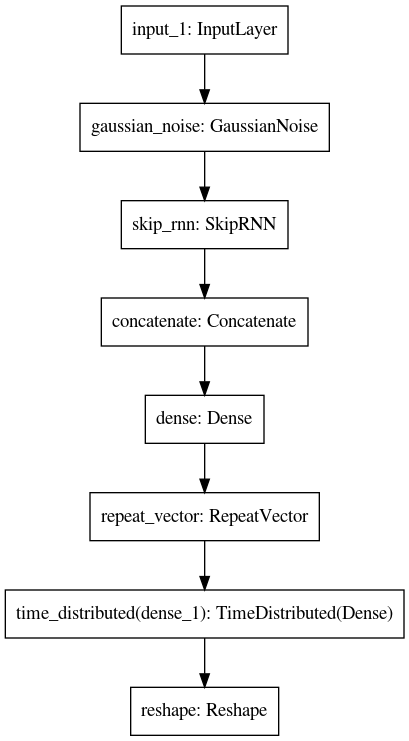

In [70]:
tf.keras.utils.plot_model(model)

### Yahoo S5

In [ ]:
total_scores = {'dataset': [], 'f1': [], 'pr_auc': [], 'roc_auc': []}

In [ ]:
for loader in [load_yahoo_A1, load_yahoo_A2, load_yahoo_A3, load_yahoo_A4]:
    datasets = loader(128, 64)
    x_trains, x_tests, y_tests = datasets['x_train'], datasets['x_test'], datasets['y_test']
    
    for i in tqdm(range(len(x_trains))):
        X_train = x_trains[i]
        X_test = x_tests[i]
        
        
        
#         N_RES = 3

#         seq_length, dim = X_train.shape[1], X_train.shape[2]
#         X_train_reverse = np.flip(X_train, axis=1)
#         X_test_reverse = np.flip(X_test, axis=1)

#         X_train_by_res = []
#         X_test_by_res = []
#         X_train_by_res_reverse = []
        
#         for n in range(N_RES):
#             selected_t = [t for t in range(0, seq_length, 2**n)]
#             X_train_by_res.append(X_train[:, selected_t, :])
#             X_test_by_res.append(X_test[:, selected_t, :])
#             X_train_by_res_reverse.append(X_train_reverse[:, selected_t, :])
        
#         model = SKip_AE(seq_length, dim, N_RES, N_LAYERS=2, BATCH_SIZE=128)
#         history = model.fit(X_train_by_res, X_train_by_res_reverse, epochs=50, batch_size=128, validation_split=0.3, verbose=0,
#                             callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min", restore_best_weights=True)]) 
        
#         X_test_rec = [np.flip(rec, axis=1) for rec in model.predict(X_test_by_res)]
#         scores = evaluate(X_test, X_test_rec[0], y_tests[i], is_reconstructed=True)
    
        total_scores['dataset'].append(loader.__name__.replace('load_', ''))
        total_scores['f1'].append(np.max(scores['f1']))
        total_scores['pr_auc'].append(scores['pr_auc'])
        total_scores['roc_auc'].append(scores['roc_auc'])
        print(loader.__name__.replace('load_', ''), np.max(scores['f1']), scores['pr_auc'], scores['roc_auc'])   

In [ ]:
yahoo_results = pd.DataFrame(total_scores)
yahoo_results.groupby('dataset').mean()

### NASA

In [ ]:
total_scores = {'dataset': [], 'f1': [], 'pr_auc': [], 'roc_auc': []}

In [ ]:
for loader in [load_nasa]:
    datasets = loader(128, 64)
    x_trains, x_tests, y_tests = datasets['x_train'], datasets['x_test'], datasets['y_test']
    
    for i in tqdm(range(len(x_trains))):
        X_train = x_trains[i]
        X_test = x_tests[i]

        
        total_scores['dataset'].append(f'D{i+1}')
        total_scores['f1'].append(np.max(scores['f1']))
        total_scores['pr_auc'].append(scores['pr_auc'])
        total_scores['roc_auc'].append(scores['roc_auc'])
        print(f'D{i+1}', np.max(scores['f1']), scores['pr_auc'], scores['roc_auc'])   

In [ ]:
nasa_results = pd.DataFrame(total_scores)
nasa_results.groupby('dataset').mean()

### SMD

In [3]:
total_scores = {'dataset': [], 'f1': [], 'pr_auc': [], 'roc_auc': []}

In [ ]:
for loader in [load_smd]:
    datasets = loader(128, 64)
    x_trains, x_tests, y_tests = datasets['x_train'], datasets['x_test'], datasets['y_test']
    
    for i in tqdm(range(len(x_trains))):
        X_train = x_trains[i]
        X_test = x_tests[i]

       
      
        total_scores['dataset'].append(loader.__name__.replace('load_', ''))
        total_scores['f1'].append(np.max(scores['f1']))
        total_scores['pr_auc'].append(scores['pr_auc'])
        total_scores['roc_auc'].append(scores['roc_auc'])
        print(loader.__name__.replace('load_', ''), np.max(scores['f1']), scores['pr_auc'], scores['roc_auc'])   

In [ ]:
smd_results = pd.DataFrame(total_scores)
smd_results.groupby('dataset').mean()

### ECG

In [ ]:
total_scores = {'dataset': [], 'f1': [], 'pr_auc': [], 'roc_auc': []}

In [ ]:
for loader in [load_ecg]:
    datasets = loader(64, 32)
    x_trains, x_tests, y_tests = datasets['x_train'], datasets['x_test'], datasets['y_test']
    
    for i in tqdm(range(len(x_trains))):
        tf.keras.backend.clear_session()

        X_train = x_trains[i]
        X_test = x_tests[i]

        model = CNN_VAE(X_train)
        
        X_test_rec = model.decoder.predict(model.encoder.predict(X_test)[-1])
        scores = evaluate(X_test, X_test_rec, y_tests[i], is_reconstructed=True)

        total_scores['dataset'].append(f'D{i+1}')
        total_scores['f1'].append(np.max(scores['f1']))
        total_scores['pr_auc'].append(scores['pr_auc'])
        total_scores['roc_auc'].append(scores['roc_auc'])
        print(f'D{i+1}', np.max(scores['f1']), scores['pr_auc'], scores['roc_auc'])  

In [ ]:
ecg_results = pd.DataFrame(total_scores)
ecg_results.groupby('dataset').mean()

### Power Demand

In [ ]:
total_scores = {'dataset': [], 'f1': [], 'pr_auc': [], 'roc_auc': []}

In [ ]:
for loader in [load_power_demand]:
    datasets = loader(512, 256)
    x_trains, x_tests, y_tests = datasets['x_train'], datasets['x_test'], datasets['y_test']
    
    for i in tqdm(range(len(x_trains))):
        tf.keras.backend.clear_session()

        X_train = x_trains[i]
        X_test = x_tests[i]

        model = CNN_VAE(X_train)
        
        X_test_rec = model.decoder.predict(model.encoder.predict(X_test)[-1])
        scores = evaluate(X_test, X_test_rec, y_tests[i], is_reconstructed=True)

        total_scores['dataset'].append(loader.__name__.replace('load_', ''))
        total_scores['f1'].append(np.max(scores['f1']))
        total_scores['pr_auc'].append(scores['pr_auc'])
        total_scores['roc_auc'].append(scores['roc_auc'])
        print(loader.__name__.replace('load_', ''), np.max(scores['f1']), scores['pr_auc'], scores['roc_auc']) 

In [ ]:
power_results = pd.DataFrame(total_scores)
power_results.groupby('dataset').mean()

### 2D Gesture

In [ ]:
total_scores = {'dataset': [], 'f1': [], 'pr_auc': [], 'roc_auc': []}

In [ ]:
for loader in [load_gesture]:
    datasets = loader(64, 32)
    x_trains, x_tests, y_tests = datasets['x_train'], datasets['x_test'], datasets['y_test']
    
    for i in tqdm(range(len(x_trains))):
        tf.keras.backend.clear_session()

        X_train = x_trains[i]
        X_test = x_tests[i]

        model = CNN_VAE(X_train)
        
        X_test_rec = model.decoder.predict(model.encoder.predict(X_test)[-1])
        scores = evaluate(X_test, X_test_rec, y_tests[i], is_reconstructed=True)

        total_scores['dataset'].append(loader.__name__.replace('load_', ''))
        total_scores['f1'].append(np.max(scores['f1']))
        total_scores['pr_auc'].append(scores['pr_auc'])
        total_scores['roc_auc'].append(scores['roc_auc'])
        print(loader.__name__.replace('load_', ''), np.max(scores['f1']), scores['pr_auc'], scores['roc_auc'])  

In [ ]:
gesture_results = pd.DataFrame(total_scores)
gesture_results.groupby('dataset').mean()